In [3]:
""" ***************************************************************************
# * File Description:                                                         *
# * Workflow for model building                                               *
# * --------------------------------------------------------------------------*
# * AUTHORS(S): Frank Ceballos <frank.ceballos89@gmail.com>                   *
# * --------------------------------------------------------------------------*
# * DATE CREATED: June 26, 2019                                               *
# * --------------------------------------------------------------------------*
# * NOTES: None                                                               *
# * ************************************************************************"""

###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# Visual bar for data generation
from tqdm.notebook import tqdm
import pickle
import os

# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [51]:
path_dataset='Observations'

BH=1 #Change this varible when using all observations

variables={'freq':[],'PS':[],'Error':[],'BH?':[]}
data=pd.DataFrame(variables)

for observation in os.listdir('Observations'):
    temp_df=pd.read_fwf(path_dataset+'/'+'95702-03-18-00_FS37_E_125.asc',skiprows=12, names=('freq','PS','Error'))

    if BH:
        temp_df['BH?']=1
    else:
        temp_df['BH?']=0
    
    data=pd.concat((data , temp_df), axis = 0,ignore_index=True)

In [52]:
x = data[['freq','PS']]
y = data[['BH?']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1000)

In [44]:
###############################################################################
#                               4. Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"K-Nearest Neighbors": KNeighborsClassifier()})
classifiers.update({"Naives Bayes": GaussianNB()})

###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with K-Nearest Neighbors Classifier
parameters.update({"K-Nearest Neighbors": {
                            "classifier__n_neighbors": [5, 10, 50, 100, 500],
                            "classifier__algorithm": ['auto','ball_tree','kd_tree','brute'],
}})

# Update dict with Naives Bayes
parameters.update({"Naives Bayes": { 

}})

# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [50, 150, 300, 500],
                                    "classifier__criterion" :["gini", "entropy", "log_loss"],
                                    "classifier__max_depth" : [3, 5, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05],
                                    "classifier__max_features": ["sqrt","log2", None],
                                    "classifier__n_jobs": [-1]
                                     }})


In [78]:
###############################################################################
#                               4. Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"K-Nearest Neighbors": KNeighborsClassifier()})
classifiers.update({"Naives Bayes": GaussianNB()})
classifiers.update({"Random Forest": RandomForestClassifier()})
###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with K-Nearest Neighbors Classifier
parameters.update({"K-Nearest Neighbors": {
                            "classifier__n_neighbors": [500],
                            "classifier__algorithm": ['auto'],
}})

# Update dict with Naives Bayes
parameters.update({"Naives Bayes": { 

}})

# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [500],
                                    "classifier__max_depth" : [8],
                                    "classifier__min_samples_split": [0.005],
                                    "classifier__min_samples_leaf": [0.005],
                                    "classifier__n_jobs": [-1]
                                     }})


In [79]:
###############################################################################
#                       13. Classifier Tuning and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
results = {}
# num_models = 0

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    try:
        # Scale features via Z-score normalization
#         scaler = StandardScaler()

        # Define steps in pipeline
#         steps = [("scaler", scaler), ("classifier", classifier)]
        steps = [("classifier", classifier)]

        # Initialize Pipeline object
        pipeline = Pipeline(steps = steps)

        # Define parameter grid
        param_grid = parameters[classifier_label]

        # Initialize GridSearch object
        gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= 4, verbose = 1, scoring = "r2")

        # Fit gscv
        gscv.fit(X_train, np.ravel(y_train))  

        # Get best parameters and score
        best_params = gscv.best_params_
        best_score = gscv.best_score_

        # Update classifier parameters and define new pipeline with tuned classifier
        tuned_params = {item[12:]: best_params[item] for item in best_params}
        classifier.set_params(**tuned_params)

        # Make predictions
        y_pred = gscv.predict(X_test)
    
        # Evaluate model
#         auc = metrics.roc_auc_score(y_test, y_pred)
#         r2 = gscv.score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Save results
        result = {"Classifier": gscv,
                  "Best Parameters": best_params,
                  "Training AUC": best_score,
                  "Test AUC": r2,
                  "Test MSE": mse}

        results.update({classifier_label: result})
        print("Finished {} training".format(classifier_label))
    except:
        print("Model {} had an error, skipping.".format(classifier_label))
            
print("Complete!")

Now tuning K-Nearest Neighbors.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finished K-Nearest Neighbors training
Now tuning Naives Bayes.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finished Naives Bayes training
Now tuning Random Forest.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finished Random Forest training
Complete!


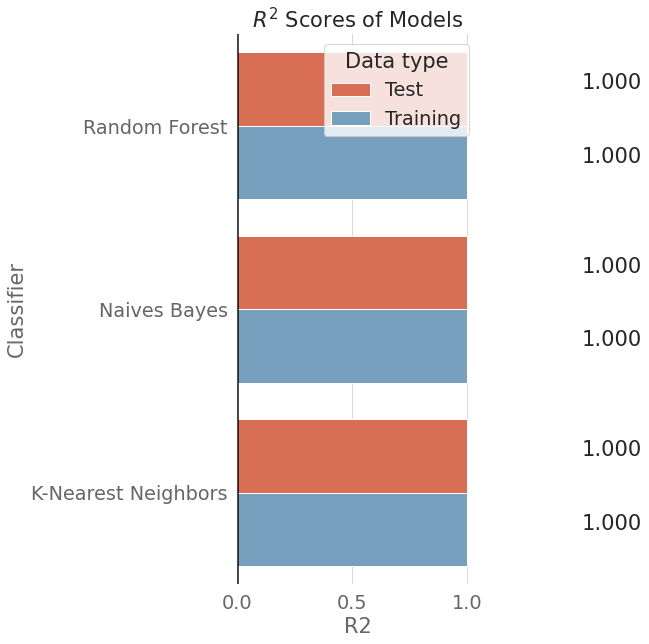

In [80]:
###############################################################################
#                              14. Visualing Results                          #
###############################################################################
# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "R2": [],
              "Data type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "R2": [results[classifier_label]["Training AUC"]] + auc_scores["R2"],
                       "Data type": ["Training"] + auc_scores["Data type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "R2": [results[classifier_label]["Test AUC"]] + auc_scores["R2"],
                       "Data type": ["Test"] + auc_scores["Data type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

p = sns.barplot(x="R2", y="Classifier", hue="Data type", palette = colors, data=auc_scores)
show_values(p, "h", space=0.5)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.title('$R^2$ Scores of Models')
plt.savefig("R2scores.png", dpi = 1080)
plt.show()

In [81]:
# Initialize auc_score dictionary
mse_scores = {
              "Classifier": [],
              "MSE": [],
              }

# Get MSE scores into dictionary
for classifier_label in results:
    mse_scores.update({"Classifier": [classifier_label] + mse_scores["Classifier"],
                       "MSE": [results[classifier_label]["Test MSE"]] + mse_scores["MSE"]})
# Best MSE scores found for the models
for model, mse in zip(mse_scores["Classifier"], mse_scores["MSE"]):
    print(f"{model:20}: {mse}")

Random Forest       : 0.0
Naives Bayes        : 0.0
K-Nearest Neighbors : 0.0


In [84]:
# Using best found parameters for Random Forest, refit the model to the training data
best_rf_params = dict()
for key, value in results['Random Forest']['Best Parameters'].items():
    best_rf_params[key.replace('classifier__', '')] = value
print(best_rf_params)

rf_classifier = RandomForestClassifier()
rf_classifier.set_params(**best_rf_params)
rf_classifier = rf_classifier.fit(X_train, np.ravel(y_train))


{'max_depth': 8, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 500, 'n_jobs': -1}


In [85]:
#Save model
import joblib
joblib.dump(rf_classifier, "./parameter_search.joblib")
#To load Parameters: load_work = joblib.load("./work.joblib")

['./parameter_search.joblib']